# Deep Convolutional Generative Adversarial Networks (DCGAN)

[Paper here](https://arxiv.org/pdf/1511.06434v2)


In [1]:
from rich import print
from tqdm.notebook import tqdm

%load_ext rich


In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
import random
import wandb

random.seed(42)
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
wandb.require('core')
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lakshyaag. Use `wandb login --relogin` to force relogin


True

In [4]:
# Hyperparameters

LATENT_DIM = 128
GEN_FEATURE_MAP = 64
DISC_FEATURE_MAP = 64

BATCH_SIZE = 128
N_EPOCHS = 50
LEARNING_RATE = 2e-4

## Load the dataset

In [5]:
transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


In [6]:
train_dataset = CIFAR10(root="./data/", download=True, train=True, transform=transform)
test_dataset = CIFAR10(root="./data/", download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
def reverse_transform(x):
    x = x * 0.5 + 0.5
    x = transforms.ToPILImage()(x)

    return x


In [8]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
len(train_loader), len(test_loader)

(391, 79)

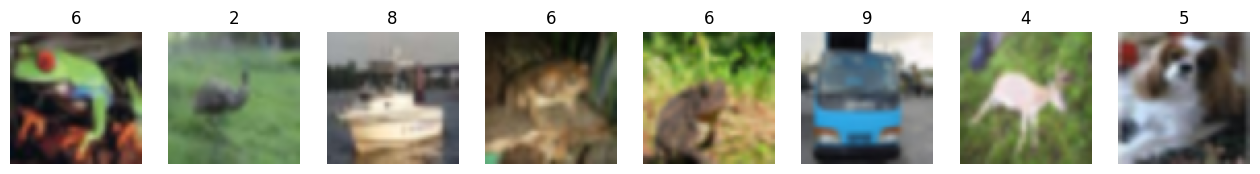

In [10]:
fig, axs = plt.subplots(1, 8, figsize=(16, 2))
indices = torch.randperm(len(train_dataset))[:8]
for i, idx in enumerate(indices):
    img, label = train_dataset[idx]
    img = reverse_transform(img)
    axs[i].imshow(img, cmap="gray")
    axs[i].set_title(label)
    axs[i].axis("off")

plt.show()

## Build the architecture

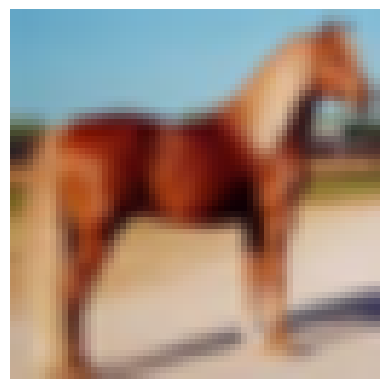

torch.Size([3, 64, 64])

7

In [11]:
sample_image, sample_label = train_loader.dataset[43]
plt.imshow(reverse_transform(sample_image))
plt.axis("off")
plt.show()

print(sample_image.shape)
print(sample_label)

In [12]:
class Generator(nn.Module):
    def __init__(self, latent_dim, feature_size, debug=False):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim
        self.feature_size = feature_size

        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                latent_dim,
                feature_size * 8,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.BatchNorm2d(feature_size * 8),
            nn.ReLU(True),
        )

        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                feature_size * 8,
                feature_size * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),
        )

        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                feature_size * 4,
                feature_size * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),
        )

        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                feature_size * 2,
                feature_size,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),
        )

        self.output = nn.Sequential(
            nn.ConvTranspose2d(
                feature_size,
                3,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.Tanh(),
        )

        self.debug = debug

        self.apply(self._init_weights)

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def _init_weights(self, m):
        if isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

        if isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        self._debug_print(x, "[GENERATOR] Input")
        x = self.conv1(x)
        self._debug_print(x, "[GENERATOR] Conv1")
        x = self.conv2(x)
        self._debug_print(x, "[GENERATOR] Conv2")
        x = self.conv3(x)
        self._debug_print(x, "[GENERATOR] Conv3")
        x = self.conv4(x)
        self._debug_print(x, "[GENERATOR] Conv4")
        x = self.output(x)
        self._debug_print(x, "[GENERATOR] Output")

        return x


[GENERATOR] Input: torch.Size([8, 128, 1, 1])

[GENERATOR] Conv1: torch.Size([8, 512, 4, 4])

[GENERATOR] Conv2: torch.Size([8, 256, 8, 8])

[GENERATOR] Conv3: torch.Size([8, 128, 16, 16])

[GENERATOR] Conv4: torch.Size([8, 64, 32, 32])

[GENERATOR] Output: torch.Size([8, 3, 64, 64])

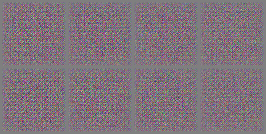

In [13]:
g = Generator(128, 64, debug=True)

reverse_transform(make_grid(g(torch.randn(8, 128, 1, 1)), nrow=4))


In [14]:
class Discriminator(nn.Module):
    def __init__(self, feature_size, debug=False):
        super(Discriminator, self).__init__()

        self.feature_size = feature_size

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=feature_size,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=feature_size,
                out_channels=feature_size * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=feature_size * 2,
                out_channels=feature_size * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=feature_size * 4,
                out_channels=feature_size * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.output = nn.Sequential(
            nn.Conv2d(
                in_channels=feature_size * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.Sigmoid(),
        )

        self.debug = debug

        self.apply(self._init_weights)

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def _init_weights(self, m):
        if isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

        if isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def forward(self, x):
        self._debug_print(x, "[DISCRIMINATOR] Input")
        x = self.conv1(x)
        self._debug_print(x, "[DISCRIMINATOR] Conv1")
        x = self.conv2(x)
        self._debug_print(x, "[DISCRIMINATOR] Conv2")
        x = self.conv3(x)
        self._debug_print(x, "[DISCRIMINATOR] Conv3")
        x = self.conv4(x)
        self._debug_print(x, "[DISCRIMINATOR] Conv4")
        x = self.output(x)
        self._debug_print(x, "[DISCRIMINATOR] Output")
        return x


In [15]:
Discriminator(64, debug=True)(train_dataset[0][0].unsqueeze(0))

[DISCRIMINATOR] Input: torch.Size([1, 3, 64, 64])

[DISCRIMINATOR] Conv1: torch.Size([1, 64, 32, 32])

[DISCRIMINATOR] Conv2: torch.Size([1, 128, 16, 16])

[DISCRIMINATOR] Conv3: torch.Size([1, 256, 8, 8])

[DISCRIMINATOR] Conv4: torch.Size([1, 512, 4, 4])

[DISCRIMINATOR] Output: torch.Size([1, 1, 1, 1])

tensor([[[[0.4937]]]], grad_fn=<SigmoidBackward0>)

In [16]:
g = Generator(latent_dim=LATENT_DIM, feature_size=GEN_FEATURE_MAP).to(device)
d = Discriminator(feature_size=DISC_FEATURE_MAP).to(device)

loss_fn = nn.BCELoss()

g_optimizer = torch.optim.Adam(g.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(d.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

print(
    f"Total number of parameters in both models: {sum(p.numel() for p in g.parameters()) + sum(p.numel() for p in d.parameters())}"
)

val_noise = torch.randn(BATCH_SIZE // 4, LATENT_DIM, 1, 1, device=device)

real_label = 1.0
fake_label = 0.0

Total number of parameters in both models: 6571648

In [17]:
wandb.init(
        project='dcgan',
        config={
            "Generator Optimizer": g_optimizer.__class__.__name__,
            "Discriminator Optimizer": d_optimizer.__class__.__name__,
            "Loss Function": loss_fn.__class__.__name__,
            "Batch Size": BATCH_SIZE,
            "Epochs": N_EPOCHS,
            "Learning Rate": LEARNING_RATE,
            "Latent Dim": LATENT_DIM,
            "Generator Feature Map Size": GEN_FEATURE_MAP,
            "Discriminator Feature Map Size": DISC_FEATURE_MAP,
            "Total Parameters": sum(p.numel() for p in g.parameters()) + sum(p.numel() for p in d.parameters()),
        },
    )

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<wandb.sdk.wandb_run.Run object at 0x7f3284fdf220>

In [18]:
val_imgs = []
g_losses = []
d_losses = []
steps = 0

for epoch in tqdm(range(N_EPOCHS), desc="Epochs"):
    # -------------------
    # Training loop
    # -------------------
    for idx, (imgs, _) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch}")):
        batch_size = imgs.size(0)
        imgs = imgs.to(device)

        ## Train Discriminator
        d_optimizer.zero_grad()
        ### Train on batch of real images
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)

        real_output = d(imgs).view(-1)

        real_loss = loss_fn(real_output, label)
        real_loss.backward()

        ### Train on batch of fake images
        noise = torch.randn(batch_size, LATENT_DIM, 1, 1, device=device)
        fake_imgs = g(noise)
        label.fill_(fake_label)

        disc_fake_output = d(fake_imgs.detach()).view(-1)

        fake_loss = loss_fn(disc_fake_output, label)
        fake_loss.backward()

        d_loss = real_loss + fake_loss
        d_optimizer.step()

        # -------------------------------

        ## Train Generator
        g_optimizer.zero_grad()
        label.fill_(real_label)

        gen_fake_output = d(fake_imgs).view(-1)

        g_loss = loss_fn(gen_fake_output, label)
        g_loss.backward()

        g_optimizer.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        # -------------------------------
        ## Training statistics
        d_x = real_output.mean().item()
        d_g_z_1 = disc_fake_output.mean().item()
        d_g_z_2 = gen_fake_output.mean().item()

        wandb.log(
            {
                "D Loss": d_loss.item(),
                "G Loss": g_loss.item(),
                "D(x)": d_x,
                "D(G(z))_1": d_g_z_1,
                "D(G(z))_2": d_g_z_2,
            }
        )

        if idx % 100 == 0:
            print(
                f"Epoch: {epoch} | Batch: {idx} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f} | D(x): {d_x:.4f} | D(G(z)): {d_g_z_1:.4f} / {d_g_z_2:.4f}"
            )

        # -------------------------------
        # Check generator output on fixed noise
        if (steps % 500 == 0) or (
            (epoch == N_EPOCHS - 1) and (idx == len(train_loader) - 1)
        ):
            with torch.no_grad():
                fake = g(val_noise).detach().cpu()
                img_grid = (make_grid(fake, padding=2))

                wandb.log({"Generated Images": [wandb.Image(img_grid, caption="Generated Images")]})
                val_imgs.append(img_grid)

        steps += 1

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 0 | Batch: 0 | D Loss: 1.3828 | G Loss: 2.8963 | D(x): 0.4322 | D(G(z)): 0.3994 / 0.0582

Epoch: 0 | Batch: 100 | D Loss: 0.8023 | G Loss: 7.2005 | D(x): 0.9141 | D(G(z)): 0.4698 / 0.0018

Epoch: 0 | Batch: 200 | D Loss: 0.0703 | G Loss: 6.2774 | D(x): 0.9540 | D(G(z)): 0.0152 / 0.0022

Epoch: 0 | Batch: 300 | D Loss: 1.8931 | G Loss: 7.2861 | D(x): 0.3723 | D(G(z)): 0.0002 / 0.0012

Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 1 | Batch: 0 | D Loss: 0.6937 | G Loss: 3.5323 | D(x): 0.8254 | D(G(z)): 0.3304 / 0.0407

Epoch: 1 | Batch: 100 | D Loss: 0.5246 | G Loss: 4.4349 | D(x): 0.9144 | D(G(z)): 0.3285 / 0.0148

Epoch: 1 | Batch: 200 | D Loss: 0.6090 | G Loss: 3.0329 | D(x): 0.8428 | D(G(z)): 0.3116 / 0.0603

Epoch: 1 | Batch: 300 | D Loss: 0.3911 | G Loss: 4.2268 | D(x): 0.8716 | D(G(z)): 0.1998 / 0.0189

Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 2 | Batch: 0 | D Loss: 0.4836 | G Loss: 2.5764 | D(x): 0.7404 | D(G(z)): 0.1152 / 0.0979

Epoch: 2 | Batch: 100 | D Loss: 0.4934 | G Loss: 4.5003 | D(x): 0.8431 | D(G(z)): 0.2274 / 0.0186

Epoch: 2 | Batch: 200 | D Loss: 0.3957 | G Loss: 3.2235 | D(x): 0.8338 | D(G(z)): 0.1612 / 0.0527

Epoch: 2 | Batch: 300 | D Loss: 0.6544 | G Loss: 3.6856 | D(x): 0.8252 | D(G(z)): 0.3335 / 0.0317

Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 3 | Batch: 0 | D Loss: 0.3892 | G Loss: 2.4200 | D(x): 0.7908 | D(G(z)): 0.1065 / 0.1236

Epoch: 3 | Batch: 100 | D Loss: 1.6951 | G Loss: 1.4381 | D(x): 0.2633 | D(G(z)): 0.0022 / 0.3231

Epoch: 3 | Batch: 200 | D Loss: 0.3353 | G Loss: 5.8946 | D(x): 0.7465 | D(G(z)): 0.0063 / 0.0057

Epoch: 3 | Batch: 300 | D Loss: 0.3656 | G Loss: 2.8249 | D(x): 0.7541 | D(G(z)): 0.0500 / 0.0943

Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 4 | Batch: 0 | D Loss: 0.3849 | G Loss: 3.4482 | D(x): 0.8844 | D(G(z)): 0.2029 / 0.0452

Epoch: 4 | Batch: 100 | D Loss: 0.4535 | G Loss: 3.3893 | D(x): 0.6879 | D(G(z)): 0.0202 / 0.0596

Epoch: 4 | Batch: 200 | D Loss: 0.4908 | G Loss: 3.6410 | D(x): 0.9097 | D(G(z)): 0.2986 / 0.0356

Epoch: 4 | Batch: 300 | D Loss: 1.5674 | G Loss: 1.5836 | D(x): 0.2816 | D(G(z)): 0.0091 / 0.2670

Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 5 | Batch: 0 | D Loss: 0.3994 | G Loss: 2.1959 | D(x): 0.7228 | D(G(z)): 0.0395 / 0.1494

Epoch: 5 | Batch: 100 | D Loss: 0.7026 | G Loss: 2.0127 | D(x): 0.5451 | D(G(z)): 0.0156 / 0.1820

Epoch: 5 | Batch: 200 | D Loss: 0.4237 | G Loss: 2.9678 | D(x): 0.8109 | D(G(z)): 0.1708 / 0.0731

Epoch: 5 | Batch: 300 | D Loss: 3.0427 | G Loss: 1.0077 | D(x): 0.0738 | D(G(z)): 0.0010 / 0.4492

Training Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 6 | Batch: 0 | D Loss: 0.5720 | G Loss: 4.4354 | D(x): 0.9694 | D(G(z)): 0.3896 / 0.0156

Epoch: 6 | Batch: 100 | D Loss: 0.4307 | G Loss: 4.0513 | D(x): 0.9302 | D(G(z)): 0.2782 / 0.0239

Epoch: 6 | Batch: 200 | D Loss: 0.9268 | G Loss: 2.3620 | D(x): 0.4873 | D(G(z)): 0.0408 / 0.1431

Epoch: 6 | Batch: 300 | D Loss: 0.1449 | G Loss: 3.3709 | D(x): 0.9376 | D(G(z)): 0.0735 / 0.0417

Training Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 7 | Batch: 0 | D Loss: 0.2106 | G Loss: 3.3387 | D(x): 0.9152 | D(G(z)): 0.1080 / 0.0463

Epoch: 7 | Batch: 100 | D Loss: 0.5809 | G Loss: 4.5976 | D(x): 0.9480 | D(G(z)): 0.3663 / 0.0157

Epoch: 7 | Batch: 200 | D Loss: 0.4062 | G Loss: 3.0467 | D(x): 0.8072 | D(G(z)): 0.1415 / 0.0708

Epoch: 7 | Batch: 300 | D Loss: 0.4388 | G Loss: 3.3741 | D(x): 0.8673 | D(G(z)): 0.2315 / 0.0467

Training Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 8 | Batch: 0 | D Loss: 5.0656 | G Loss: 4.0542 | D(x): 0.9993 | D(G(z)): 0.9758 / 0.0472

Epoch: 8 | Batch: 100 | D Loss: 0.1789 | G Loss: 3.4536 | D(x): 0.8864 | D(G(z)): 0.0501 / 0.0403

Epoch: 8 | Batch: 200 | D Loss: 0.9456 | G Loss: 5.2906 | D(x): 0.9800 | D(G(z)): 0.5407 / 0.0077

Epoch: 8 | Batch: 300 | D Loss: 0.2953 | G Loss: 4.9272 | D(x): 0.9512 | D(G(z)): 0.2038 / 0.0107

Training Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 9 | Batch: 0 | D Loss: 0.1560 | G Loss: 2.9686 | D(x): 0.9218 | D(G(z)): 0.0657 / 0.0691

Epoch: 9 | Batch: 100 | D Loss: 0.3608 | G Loss: 3.4711 | D(x): 0.8416 | D(G(z)): 0.1411 / 0.0428

Epoch: 9 | Batch: 200 | D Loss: 0.5311 | G Loss: 2.4243 | D(x): 0.6760 | D(G(z)): 0.0738 / 0.1096

Epoch: 9 | Batch: 300 | D Loss: 0.0788 | G Loss: 3.6843 | D(x): 0.9579 | D(G(z)): 0.0336 / 0.0335

Training Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 10 | Batch: 0 | D Loss: 0.8918 | G Loss: 1.2178 | D(x): 0.4891 | D(G(z)): 0.0594 / 0.3519

Epoch: 10 | Batch: 100 | D Loss: 0.3200 | G Loss: 3.1664 | D(x): 0.8281 | D(G(z)): 0.1025 / 0.0611

Epoch: 10 | Batch: 200 | D Loss: 0.3201 | G Loss: 2.3723 | D(x): 0.8872 | D(G(z)): 0.1636 / 0.1166

Epoch: 10 | Batch: 300 | D Loss: 0.9044 | G Loss: 4.3873 | D(x): 0.9801 | D(G(z)): 0.4966 / 0.0203

Training Epoch 11:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 11 | Batch: 0 | D Loss: 0.9333 | G Loss: 6.1401 | D(x): 0.9405 | D(G(z)): 0.5260 / 0.0035

Epoch: 11 | Batch: 100 | D Loss: 0.4136 | G Loss: 3.7504 | D(x): 0.8629 | D(G(z)): 0.2082 / 0.0333

Epoch: 11 | Batch: 200 | D Loss: 0.1036 | G Loss: 4.5804 | D(x): 0.9847 | D(G(z)): 0.0818 / 0.0141

Epoch: 11 | Batch: 300 | D Loss: 0.0455 | G Loss: 7.8707 | D(x): 0.9569 | D(G(z)): 0.0005 / 0.0006

Training Epoch 12:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 12 | Batch: 0 | D Loss: 0.5598 | G Loss: 5.6363 | D(x): 0.9820 | D(G(z)): 0.3770 / 0.0053

Epoch: 12 | Batch: 100 | D Loss: 0.1585 | G Loss: 6.0849 | D(x): 0.9866 | D(G(z)): 0.1278 / 0.0035

Epoch: 12 | Batch: 200 | D Loss: 0.1136 | G Loss: 4.1064 | D(x): 0.9719 | D(G(z)): 0.0781 / 0.0264

Epoch: 12 | Batch: 300 | D Loss: 0.5285 | G Loss: 2.5077 | D(x): 0.6943 | D(G(z)): 0.0940 / 0.1154

Training Epoch 13:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 13 | Batch: 0 | D Loss: 0.2202 | G Loss: 3.3707 | D(x): 0.8490 | D(G(z)): 0.0414 / 0.0492

Epoch: 13 | Batch: 100 | D Loss: 0.0438 | G Loss: 4.8311 | D(x): 0.9683 | D(G(z)): 0.0109 / 0.0121

Epoch: 13 | Batch: 200 | D Loss: 1.0228 | G Loss: 1.1368 | D(x): 0.5084 | D(G(z)): 0.1987 / 0.3704

Epoch: 13 | Batch: 300 | D Loss: 0.1286 | G Loss: 4.8049 | D(x): 0.9921 | D(G(z)): 0.1088 / 0.0112

Training Epoch 14:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 14 | Batch: 0 | D Loss: 0.4557 | G Loss: 2.6685 | D(x): 0.7701 | D(G(z)): 0.1344 / 0.1061

Epoch: 14 | Batch: 100 | D Loss: 1.1421 | G Loss: 0.2885 | D(x): 0.4244 | D(G(z)): 0.0372 / 0.7813

Epoch: 14 | Batch: 200 | D Loss: 0.6398 | G Loss: 4.5451 | D(x): 0.9660 | D(G(z)): 0.4143 / 0.0154

Epoch: 14 | Batch: 300 | D Loss: 0.6949 | G Loss: 2.0967 | D(x): 0.5869 | D(G(z)): 0.0839 / 0.1714

Training Epoch 15:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 15 | Batch: 0 | D Loss: 0.1886 | G Loss: 3.6611 | D(x): 0.8639 | D(G(z)): 0.0322 / 0.0384

Epoch: 15 | Batch: 100 | D Loss: 0.0408 | G Loss: 5.3687 | D(x): 0.9729 | D(G(z)): 0.0127 / 0.0071

Epoch: 15 | Batch: 200 | D Loss: 0.4791 | G Loss: 2.7469 | D(x): 0.7980 | D(G(z)): 0.1849 / 0.0939

Epoch: 15 | Batch: 300 | D Loss: 0.9987 | G Loss: 4.5622 | D(x): 0.9101 | D(G(z)): 0.5402 / 0.0152

Training Epoch 16:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 16 | Batch: 0 | D Loss: 0.3598 | G Loss: 3.7014 | D(x): 0.9210 | D(G(z)): 0.2154 / 0.0340

Epoch: 16 | Batch: 100 | D Loss: 0.0330 | G Loss: 4.7497 | D(x): 0.9933 | D(G(z)): 0.0255 / 0.0135

Epoch: 16 | Batch: 200 | D Loss: 0.4968 | G Loss: 2.5705 | D(x): 0.7473 | D(G(z)): 0.1375 / 0.1098

Epoch: 16 | Batch: 300 | D Loss: 0.8443 | G Loss: 6.1748 | D(x): 0.9696 | D(G(z)): 0.5132 / 0.0032

Training Epoch 17:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 17 | Batch: 0 | D Loss: 0.6665 | G Loss: 2.5966 | D(x): 0.7790 | D(G(z)): 0.3035 / 0.0968

Epoch: 17 | Batch: 100 | D Loss: 0.0173 | G Loss: 6.0954 | D(x): 0.9857 | D(G(z)): 0.0028 / 0.0034

Epoch: 17 | Batch: 200 | D Loss: 0.4171 | G Loss: 3.7386 | D(x): 0.9448 | D(G(z)): 0.2744 / 0.0332

Epoch: 17 | Batch: 300 | D Loss: 0.0157 | G Loss: 7.4631 | D(x): 0.9860 | D(G(z)): 0.0010 / 0.0008

Training Epoch 18:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 18 | Batch: 0 | D Loss: 0.5074 | G Loss: 1.5577 | D(x): 0.7560 | D(G(z)): 0.1446 / 0.2744

Epoch: 18 | Batch: 100 | D Loss: 0.4553 | G Loss: 3.0329 | D(x): 0.8453 | D(G(z)): 0.2175 / 0.0705

Epoch: 18 | Batch: 200 | D Loss: 0.8538 | G Loss: 1.2663 | D(x): 0.5034 | D(G(z)): 0.0582 / 0.3571

Epoch: 18 | Batch: 300 | D Loss: 1.0639 | G Loss: 1.0596 | D(x): 0.4909 | D(G(z)): 0.1959 / 0.3937

Training Epoch 19:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 19 | Batch: 0 | D Loss: 0.2028 | G Loss: 3.4692 | D(x): 0.9748 | D(G(z)): 0.1508 / 0.0420

Epoch: 19 | Batch: 100 | D Loss: 0.0207 | G Loss: 7.6284 | D(x): 0.9807 | D(G(z)): 0.0010 / 0.0008

Epoch: 19 | Batch: 200 | D Loss: 0.8677 | G Loss: 0.7271 | D(x): 0.4930 | D(G(z)): 0.0313 / 0.5455

Epoch: 19 | Batch: 300 | D Loss: 0.1542 | G Loss: 4.9305 | D(x): 0.8712 | D(G(z)): 0.0078 / 0.0109

Training Epoch 20:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 20 | Batch: 0 | D Loss: 1.1536 | G Loss: 0.7948 | D(x): 0.3983 | D(G(z)): 0.0359 / 0.5185

Epoch: 20 | Batch: 100 | D Loss: 0.5263 | G Loss: 2.2832 | D(x): 0.8862 | D(G(z)): 0.2891 / 0.1305

Epoch: 20 | Batch: 200 | D Loss: 0.8127 | G Loss: 2.5614 | D(x): 0.7588 | D(G(z)): 0.3664 / 0.0954

Epoch: 20 | Batch: 300 | D Loss: 0.0435 | G Loss: 5.7098 | D(x): 0.9639 | D(G(z)): 0.0062 / 0.0049

Training Epoch 21:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 21 | Batch: 0 | D Loss: 0.6940 | G Loss: 2.7428 | D(x): 0.7624 | D(G(z)): 0.2770 / 0.0922

Epoch: 21 | Batch: 100 | D Loss: 0.4295 | G Loss: 2.2730 | D(x): 0.7695 | D(G(z)): 0.1249 / 0.1342

Epoch: 21 | Batch: 200 | D Loss: 0.6795 | G Loss: 1.6456 | D(x): 0.6055 | D(G(z)): 0.0908 / 0.2350

Epoch: 21 | Batch: 300 | D Loss: 0.4612 | G Loss: 2.3977 | D(x): 0.8444 | D(G(z)): 0.2206 / 0.1176

Training Epoch 22:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 22 | Batch: 0 | D Loss: 0.0415 | G Loss: 4.5904 | D(x): 0.9905 | D(G(z)): 0.0309 / 0.0146

Epoch: 22 | Batch: 100 | D Loss: 0.0136 | G Loss: 5.0734 | D(x): 0.9989 | D(G(z)): 0.0124 / 0.0091

Epoch: 22 | Batch: 200 | D Loss: 0.1627 | G Loss: 3.8903 | D(x): 0.9299 | D(G(z)): 0.0803 / 0.0288

Epoch: 22 | Batch: 300 | D Loss: 0.8973 | G Loss: 2.2985 | D(x): 0.4827 | D(G(z)): 0.0035 / 0.1664

Training Epoch 23:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 23 | Batch: 0 | D Loss: 0.5573 | G Loss: 2.7607 | D(x): 0.8039 | D(G(z)): 0.2441 / 0.0848

Epoch: 23 | Batch: 100 | D Loss: 0.0237 | G Loss: 6.5225 | D(x): 0.9814 | D(G(z)): 0.0046 / 0.0025

Epoch: 23 | Batch: 200 | D Loss: 0.0818 | G Loss: 4.3012 | D(x): 0.9741 | D(G(z)): 0.0520 / 0.0213

Epoch: 23 | Batch: 300 | D Loss: 0.4286 | G Loss: 2.4658 | D(x): 0.7727 | D(G(z)): 0.1295 / 0.1134

Training Epoch 24:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 24 | Batch: 0 | D Loss: 0.2956 | G Loss: 3.9527 | D(x): 0.9266 | D(G(z)): 0.1708 / 0.0337

Epoch: 24 | Batch: 100 | D Loss: 0.9700 | G Loss: 1.9756 | D(x): 0.4458 | D(G(z)): 0.0215 / 0.1923

Epoch: 24 | Batch: 200 | D Loss: 0.3534 | G Loss: 2.0117 | D(x): 0.7633 | D(G(z)): 0.0608 / 0.1641

Epoch: 24 | Batch: 300 | D Loss: 0.4797 | G Loss: 1.9845 | D(x): 0.7061 | D(G(z)): 0.0798 / 0.1878

Training Epoch 25:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 25 | Batch: 0 | D Loss: 0.1633 | G Loss: 4.1891 | D(x): 0.8657 | D(G(z)): 0.0099 / 0.0238

Epoch: 25 | Batch: 100 | D Loss: 0.0254 | G Loss: 5.0932 | D(x): 0.9970 | D(G(z)): 0.0213 / 0.0090

Epoch: 25 | Batch: 200 | D Loss: 0.6382 | G Loss: 5.3374 | D(x): 0.9408 | D(G(z)): 0.3863 / 0.0080

Epoch: 25 | Batch: 300 | D Loss: 0.7682 | G Loss: 3.5630 | D(x): 0.8286 | D(G(z)): 0.3813 / 0.0394

Training Epoch 26:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 26 | Batch: 0 | D Loss: 1.0439 | G Loss: 1.3831 | D(x): 0.4299 | D(G(z)): 0.0312 / 0.3130

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:10                                                                                   │
│                                                                                                  │
│    7 │   # -------------------                                                                   │
│    8 │   # Training loop                                                                         │
│    9 │   # -------------------                                                                   │
│ ❱ 10 │   for idx, (imgs, _) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch}")):    │
│   11 │   │   batch_size = imgs.size(0)                                                           │
│   12 │   │   imgs = imgs.to(device)                                                              │
│   13                                                                                             │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tqdm/notebook.py:250 in       │
│ __iter__                                                                                         │
│                                                                                                  │
│   247 │   def __iter__(self):                                                                    │
│   248 │   │   try:                                                                               │
│   249 │   │   │   it = super().__iter__()                                                        │
│ ❱ 250 │   │   │   for obj in it:                                                                 │
│   251 │   │   │   │   # return super(tqdm...) will not catch exception                           │
│   252 │   │   │   │   yield obj                                                                  │
│   253 │   │   # NB: except ... [ as ...] breaks IPython async KeyboardInterrupt                  │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tqdm/std.py:1181 in __iter__  │
│                                                                                                  │
│   1178 │   │   time = self._time                                                                 │
│   1179 │   │                                                                                     │
│   1180 │   │   try:                                                                              │
│ ❱ 1181 │   │   │   for obj in iterable:                                                          │
│   1182 │   │   │   │   yield obj                                                                 │
│   1183 │   │   │   │   # Update and possibly print the progressbar.                              │
│   1184 │   │   │   │   # Note: does not call self.update(1) for speed optimisation.              │
│                                                                                                  │
│ /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/data/dataloader.p │
│ y:631 in __next__                                                                                │
│                                                                                                  │
│    628 │   │   │   if self._sampler_iter is None:                                                │
│    629 │   │   │   │   # TODO(https://github.com/pytorch/pytorch/issues/76750)                   │
│    630 │   │   │   │   self._reset()  # type: ignore[call-arg]                                   │
│ ❱  631 │   │   │   data = self._next_data()                                                      │
│    632 │   │   │   self._num_yielded += 1                  

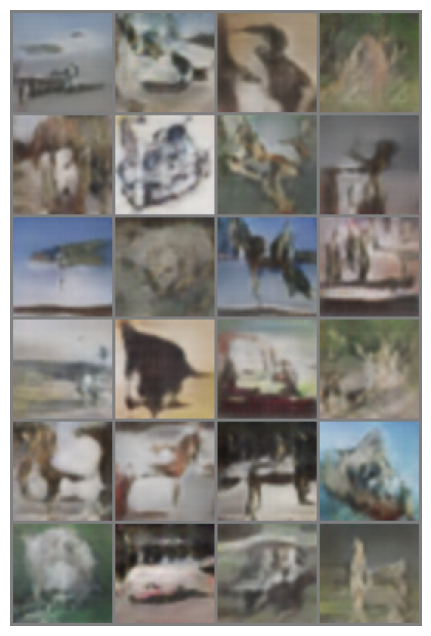

In [21]:
g.eval()
d.eval()

plt.figure(figsize=(8, 8))
plt.imshow(
    reverse_transform(make_grid(g(val_noise)[8:32], nrow=4))
)
plt.axis("off")
plt.show()

In [20]:
wandb.finish()

D Loss,▂▂▂▅█▄▄▃▃▃▅▆▅▄▂▂▂▄▃▁▄▆▄▁▃█▁▃▃▆▆▂▅▁▁▃▂▁▄▃
D(G(z))_1,▂▃▁▁▃▂▅▁▂▂▂▁▂▂▂▁▁▃▁▁▂▁▂▂▅▃▁▁▂▇▃▃▃▄▃▂█▁▁▁
D(G(z))_2,▁▁▁▁▂▁▁▁▁▂▁▂▁▁▂▁▁▂█▁▁▁▁▁▁▁▁▁▂▂▃▃▁▂▂▁▃▂▁▁
D(x),▁▇▇▇▅█▆▇▅▇▇▅▃█▅▄▇▇█▃▅▆▇▄█▅▃▅▅▆▇██▇▅█▅▇██
G Loss,▇▅▄▆▄▂██▄▃▃▃▃▃▅▅▃▃▃▄▄▄▅▃▃▁▃▄▄▃▄▃▆▃▆▄▆▆▆▆
D Loss,1.15088
D(G(z))_1,0.32591
D(G(z))_2,0.10975
D(x),0.70724
G Loss,2.9551


<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

In [23]:
torch.save(g.state_dict(), "./models/dcgan.pth")